# Problem

Implement a **DNN** based **regression** model, using **tensorflow**, on a **dataset of your choice**.

# Dataset

We will be using the [Year Prediction Million Song Dataset][1] from the UCI Machine Learning Repository:

> **Abstract:** 
  * Prediction of the release year of a song from audio features. 
  * Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s.
  
  |                           |   
  | ------------------------- |:------------- 
  | Data Set Characteristics: | Multivariate 
  | Number of Instances:      | 515345   
  | Attribute Characteritics: | Real     
  | Number of Attributes:     | 90
  | Date Donated:             | 2011-02-07
  | Associated Tasks:         | Regression
  | Missing Values:           | N/A
  | Number of Web Hits:       | 103568

> **Source:** 
  * This data is a subset of the [Million Song Dataset][2], a collaboration between LabROSA 
  (Columbia University) and The Echo Nest. 
  * Prepared by T. Bertin-Mahieux <tb2332 '@' columbia.edu>

> **Data Set Information:** 
  * You should respect the following train / test split: 
    * `train`: first 463,715 examples 
    * `test`: last 51,630 examples 
  * It avoids the 'producer effect' by making sure no song from a given artist ends up in both 
  the train and test set.

> **Attribute Information:** 
  * 90 attributes, 12 = timbre average, 78 = timbre covariance 
  * The first value is the year (target), ranging from 1922 to 2011. 
  * Features extracted from the 'timbre' features from The Echo Nest API. 
  * We take the average and covariance over all 'segments', each segment being described by a 
  12-dimensional timbre vector.



[1]: https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd#
[2]: http://labrosa.ee.columbia.edu/millionsong/ 

# Prepare the Data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

In [3]:
# Load the raw data.
num_attributes = 90
names = ['Year'] + ['Attr_{}'.format(i) for i in xrange(num_attributes)]
df = pd.read_csv('YearPredictionMSD.txt', header=None, names=names)

# Validate the data.
num_examples = 515345
assert len(df.columns) == num_attributes + 1
assert len(df) == num_examples
assert not df.isnull().values.any()


# Train/test split. See "Data Set Information".
num_train = 463715
df = df.as_matrix()
train = df[:num_train]
test = df[num_train:]
del df


# Train/val split.
train, val = train_test_split(train, test_size=0.2, shuffle=True)
print 'Train/val/test split: {:.0f}/{:.0f}/{:.0f}'.format(len(train) / float(num_examples) * 100, 
                                              len(val) / float(num_examples) * 100, 
                                              len(test) / float(num_examples) * 100)

# Seperate inputs and outputs.
X_train, y_train = train[:, 1:], train[:, 0]
X_val, y_val = val[:, 1:], val[:, 0]
X_test, y_test = test[:, 1:], test[:, 0]
del train
del val
del test

# Scale data i.e. mean 0 and std 1.
X_train, X_val, X_test = map(preprocessing.scale, [X_train, X_val, X_test])

Train/val/test split: 72/18/10


# Model Tuning/Training

## Baseline

Let's train a simple model on each available optimizer, with it's default hyperparameters, and select the best performing as our baseline.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # Applies seaborn style defaults to matplotlib

from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

import random

In [5]:
def plot(history):
    epochs = xrange(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label='train');
    plt.plot(epochs, history.history['val_loss'], label='val');
    plt.xlabel('epoch');
    plt.ylabel('mae');
    plt.legend();
    plt.show();

In [38]:
batch_size = 32
num_epochs = 4
    
model = Sequential()
model.add(Dense(input_dim=num_attributes, units=32, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size=batch_size, 
                    epochs=num_epochs)

Train on 370972 samples, validate on 92743 samples
Epoch 1/4
370972/370972 [==============================]370972/370972 [==============================] - 16s 42us/step - loss: 931160.4283 - mean_absolute_error: 729.0378 - val_loss: 114339.5501 - val_mean_absolute_error: 248.9556

Epoch 2/4
370972/370972 [==============================]370972/370972 [==============================] - 14s 37us/step - loss: 33811.4994 - mean_absolute_error: 110.8175 - val_loss: 1369.0618 - val_mean_absolute_error: 20.9022

Epoch 3/4
370972/370972 [==============================]370972/370972 [==============================] - 14s 36us/step - loss: 377.6239 - mean_absolute_error: 10.2197 - val_loss: 141.2830 - val_mean_absolute_error: 7.9505

Epoch 4/4
370972/370972 [==============================]370972/370972 [==============================] - 14s 38us/step - loss: 130.5977 - mean_absolute_error: 7.5514 - val_loss: 116.1012 - val_mean_absolute_error: 7.4958



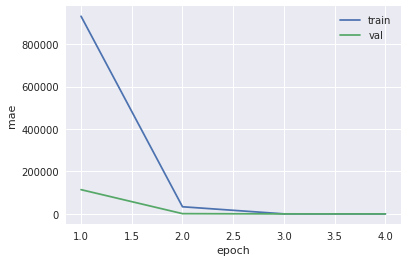

In [39]:
plot(history)

## That's not right...

**Problem:** The val mae is consistently better than the training mae (i.e. over many experiments with varying optimizers and network depths and widths).

**Thoughts:** The model is **overfitting**.

**Solutions:**
  * regularize -> failed
  * increase validation size -> failed
  
So what is going on? Maybe my val set is just **"easier"** than my train set perhaps as a result of the **"producer effect"**. Whatever the cause, **let's assume that the cause is not overfitting**.

## So what is our DNN baseline?

In [40]:
print 'DNN baseline mae: {}'.format(history.history['mean_absolute_error'][-1])

DNN baseline mae: 7.55136121564


Furthermore, work done by [Tan et al.][1] shows a best **MAE** of **~6.97** using a **Random Forest**. 

[1]: https://cseweb.ucsd.edu/classes/wi17/cse258-a/reports/a028.pdf

## Can we do better?

Many hours and random searches later...

In [41]:
from tensorflow.python.keras.optimizers import RMSprop

In [46]:
num_experiments = 1
num_epochs = 12

for i in xrange(num_experiments):
    depth = 1
    units = 32
    lr = 0.0011
    
    model = Sequential()
    model.add(Dense(input_dim=num_attributes, units=units, activation='relu'))
    model.add(Dense(units=1))

    model.compile(optimizer=RMSprop(lr), loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        batch_size=batch_size, 
                        epochs=num_epochs, 
                        callbacks=[],
                        verbose=True)

Train on 370972 samples, validate on 92743 samples
Epoch 1/12
370972/370972 [==============================]370972/370972 [==============================] - 15s 42us/step - loss: 871375.7287 - mean_absolute_error: 694.2535 - val_loss: 84390.0757 - val_mean_absolute_error: 209.6151

Epoch 2/12
370972/370972 [==============================]370972/370972 [==============================] - 14s 39us/step - loss: 19967.4339 - mean_absolute_error: 80.3425 - val_loss: 521.5517 - val_mean_absolute_error: 12.4457

Epoch 3/12
370972/370972 [==============================]370972/370972 [==============================] - 14s 37us/step - loss: 209.3384 - mean_absolute_error: 8.5453 - val_loss: 135.1736 - val_mean_absolute_error: 7.9591

Epoch 4/12
370972/370972 [==============================]370972/370972 [==============================] - 14s 38us/step - loss: 121.7016 - mean_absolute_error: 7.5443 - val_loss: 115.2520 - val_mean_absolute_error: 7.2185

Epoch 5/12
370972/370972 [==================

# Results

It turns out that a DNN with 1 hidden layer and 32 hidden units is as good as any DNN. By fine tuning the lr and training for more epochs, we were able to improve on the DNN baseline. So the question now becomes, how well does it perform on the test set?

In [51]:
_, mae = model.evaluate(X_test, y_test, verbose=False)
print mae

7.215515756209922
